In [1]:
import pandas as pd
import numpy as np
import xarray
import matplotlib.pyplot as plt

In [2]:
def rmse(inp):
    return np.sqrt((inp**2).mean())


def ACC(FC,OBS,CL):
    'Correlation coefficient between forecast and observed anomalies from climate'
    top = np.mean((FC-CL)*(OBS-CL))
    bottom  = np.sqrt(np.mean((FC-CL)**2)*np.mean((OBS-CL)**2))
    ACC = top/bottom
    return ACC

def Climatology(data):
    dt= 15 ##window
    dy = 366 # number of days in a year
    climatology = data.copy()
    for i in np.arange(1,367):
            if i<(dt+1):
                i1 = dy+i-dt
                i2 = i+dt
                CLIMATE = data[(data.index.dayofyear>=i1)|(data.index.dayofyear<=i2)]
            elif i>(dy-dt):
                i1 = i-dt
                i2 = i+dt-dy
                CLIMATE = data[(data.index.dayofyear>=i1)|(data.index.dayofyear<=i2)]
            else:
                i1 = i-dt
                i2 = i+dt
                CLIMATE = data[(data.index.dayofyear>=i1)&(data.index.dayofyear<=i2)]
            climatology.values[climatology.index.dayofyear==i] = np.nanmean(CLIMATE.values)            
    return climatology



def PlotBarsDots_stations(me_I,me_E,me_M,rmse_I, rmse_E, rmse_M, UNITS='',method='NN', leg_YN = False, fileNAME='Overall.pdf'):
    st_label = (['BT','BR','CA','CM','CS','DA','KK','MH','MR','RL','SA','VO'])
    Fsize=12
    plt.figure(figsize=(5,4))
    ind=np.arange(12)
    width=0.25
    i_col = 'r'
    e_col= 'g'
    m_col = 'b'
    Msize=6

    plt.bar(ind,me_I,width,color=i_col,edgecolor = 'k', label='ME MÉRA')
    plt.bar(ind+width,me_E,width,color=e_col,edgecolor='k', label='ME ERA-Interim')
    plt.bar(ind+(width*2),me_M,width,color=m_col,edgecolor ='k' ,label='ME MERRA2')
    plt.plot(ind,rmse_I, 'o',markersize=Msize, color=i_col, mec='k', label='RMSE MÉRA')
    plt.plot(ind+width,rmse_E,'o',markersize=Msize,color=e_col,mec='k', label='RMSE ERA-Interim')
    plt.plot(ind+(width*2),rmse_M,'o',markersize=Msize,color=m_col, mec='k', label='RMSE MERRA2')
    
    plt.xticks(np.arange(0,12)+0.25,st_label,rotation=0, fontsize=Fsize)
    plt.yticks(np.arange(-2,5,1))
    plt.ylabel('%s'%(UNITS), fontsize=Fsize)
    plt.tick_params(axis='y',direction='out',left=True,labelsize=Fsize)
    plt.tick_params(axis='y',direction='in',right=True)
    if leg_YN==True:
        plt.legend(loc=2,ncol=2,fontsize=8)
    plt.grid(axis='y',linestyle='dotted',color='k')
    if method=='NN':
        plt.title('Overall: Nearest Grid Point',fontsize=12)
    else:
        plt.title('Overall: Bilinear Interpolation',fontsize=12)
    plt.xlim([-0.3,11.8])
    plt.ylim(-2.05,4.85)
    plt.savefig('%s'%(fileNAME),bbox_inches='tight',dpi=300)

    
def PlotMonthlyBarsDots(Values_ME,Values_RMSE, unit,ymin,ymax, method,fileNAME='Monthly'):
    width=0.3
    plt.clf()
    ind = np.arange(12)
    plt.figure(figsize=(5,3))
    Fsize=12
    hat = '//'
    o_col = 'w'
    i_col = 'r'
    e_col= 'g'
    m_col = 'b'
    Msize=6
    
    
    plt.bar( ind, Values_ME['MERA'], width, color=i_col, edgecolor='k',label='ME - MÉRA')
    plt.bar( ind+(width), Values_ME['ERI'], width, color=e_col,edgecolor='k', label='ME - ERA-Interim')
    plt.bar( ind+(width*2), Values_ME['MR2'], width, color=m_col,edgecolor='k', label='ME - MERRA-2')
    plt.plot(ind,Values_RMSE['MERA'], 'o',markersize=Msize,color=i_col,mec='k',label='RMSE - MÉRA')
    plt.plot(ind+(width),Values_RMSE['ERI'], 'o',markersize=Msize,color=e_col, mec='k', label='RMSE - ERA-Interim')
    plt.plot(ind+(width*2),Values_RMSE['MR2'], 'o',markersize=Msize,color=m_col,mec= 'k',  label='RMSE - MERRA-2')
    plt.xticks(np.arange(0.25,13,1),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation=90, fontsize=Fsize)
    plt.tick_params(axis='y',labelsize=Fsize)
    plt.tick_params(axis='x',labelsize=Fsize)
    plt.grid(axis='y',linestyle='dotted')
    if method=='NN':
        plt.title('Monthly: Nearest Grid Point')
    else:
        plt.title('Monthly: Bilinear Interpolation')
    plt.xlim([-0.5,12])
    plt.ylabel('%s'%unit,fontsize=Fsize)
    plt.ylim([ymin,ymax])
    plt.savefig('%s.pdf'%(fileNAME),bbox_inches='tight',dpi=300)



In [3]:
stn_list=['Belmullet','Birr','Cork_Airport','Claremorris','Clones','Dublin_Airport','Kilkenny','Malin_Head','Mullingar','Rosslare','Shannon_Airport','Valentia_Observatory']


OBS_DIR=''

METHOD = 'NN' #NN or BI

#Location for reanalysis data, either NN or BI data
REANALYSIS_DIR=''


combo_error = pd.DataFrame()

#Dataframe to store skill scores at each station: ME, RMSE, r and ACC
ME_df = pd.DataFrame(index = stn_list,columns=['MERA wspd','ERA-I wspd','MERRA2 wspd'])
RMSE_df = pd.DataFrame(index = stn_list,columns=['MERA wspd','ERA-I wspd','MERRA2 wspd'])
ACC_df = pd.DataFrame(index = stn_list,columns=['MERA wspd','ERA-I wspd','MERRA2 wspd'])
r_df = pd.DataFrame(index = stn_list,columns=['MERA wspd','ERA-I wspd','MERRA2 wspd'])


for STN in stn_list:
    #Read in reanalysis data, organise and concatenate into pandas dataframe
    x_mera = xarray.open_dataset(REANALYSIS_DIR+STN+'_MERA.nc').isel(height=0,lat=0,lon=0)
    x_era = xarray.open_dataset(REANALYSIS_DIR+STN+'_ERA.nc').isel(lat=0,lon=0)
    x_mr2 = xarray.open_dataset(REANALYSIS_DIR+STN+'_MERRA2.nc').isel(lat=0,lon=0)

    ser_EI = x_era.to_dataframe()['wspd'].rename('ERA-I wspd').to_frame()
    ser_MERA = x_mera.to_dataframe()['wspd'].rename('MERA wspd').to_frame().resample('D').mean()
    ser_MR2 = x_mr2.to_dataframe()['wspd'].rename('MERRA2 wspd').to_frame()
    
    reanalysis_DF = pd.concat([ser_MERA,ser_EI,ser_MR2],axis=1)['19820101':'20071231']
    
    #Read in Obs data
    obs = pd.read_csv(OBS_DIR+STN+'_Obs.csv',index_col=0,parse_dates=True)[:'20071231']
    dnan = obs.isnull().resample('D').sum()['obs wspd']
    obs = obs.resample('D').mean()*0.51444
    #Filter out days with more than 3 missing obs values
    obs = obs[dnan<3].reindex(reanalysis_DF.index)

    
    # Calculate errors (model - obs). Append errors for this station to overall errors
    error_DF = (reanalysis_DF - obs.values)
    combo_error = pd.concat([combo_error,error_DF],axis=0)

    print(STN)
    print(pd.concat([error_DF.mean().rename('ME'),error_DF.apply(rmse).rename('RMSE'),error_DF.std().rename('std')],axis=1))
    

    # Calculate ME, RMSE, r and ACC for station 'STN', to store for comparison of different stations
    ME_df.loc[STN] = error_DF.mean()
    RMSE_df.loc[STN] = error_DF.apply(rmse)
    r_df.loc[STN] = pd.concat([obs,reanalysis_DF],axis=1).corr(method='pearson').iloc[0,1:]

    for col in reanalysis_DF.columns:
        ACC_df.loc[STN,col] = ACC(reanalysis_DF[col],obs['obs wspd'],Climatology(obs)['obs wspd'])
    

Belmullet
                   ME      RMSE       std
MERA wspd   -0.565493  1.083305  0.924045
ERA-I wspd   0.651576  1.339393  1.170285
MERRA2 wspd  0.788483  1.390688  1.145621
Birr
                   ME      RMSE       std
MERA wspd    1.536800  1.756891  0.851462
ERA-I wspd   1.428435  1.662926  0.851453
MERRA2 wspd  1.989544  2.198826  0.936292
Cork_Airport
                   ME      RMSE       std
MERA wspd   -0.019384  0.900040  0.899879
ERA-I wspd   2.233943  2.784862  1.662903
MERRA2 wspd  0.138534  1.021468  1.012083
Claremorris
                   ME      RMSE       std
MERA wspd    0.740593  1.136733  0.862417
ERA-I wspd   1.531362  1.851685  1.041049
MERRA2 wspd  0.967380  1.301309  0.870437
Clones
                   ME      RMSE       std
MERA wspd    0.856474  1.169051  0.795739
ERA-I wspd   0.964344  1.273833  0.832324
MERRA2 wspd  1.387805  1.638961  0.871935
Dublin_Airport
                   ME      RMSE       std
MERA wspd   -0.422236  0.781963  0.658201
ERA-I wspd   2

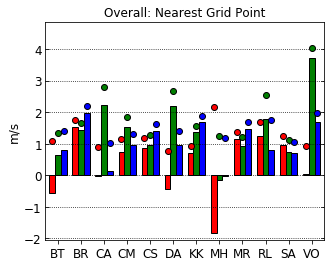

In [4]:
PlotBarsDots_stations(ME_df['MERA wspd'], ME_df['ERA-I wspd'], ME_df['MERRA2 wspd'], RMSE_df['MERA wspd'], RMSE_df['ERA-I wspd'], RMSE_df['MERRA2 wspd'],'m/s',method=METHOD,fileNAME='COMBO_'+METHOD+'_wind.pdf')

<Figure size 432x288 with 0 Axes>

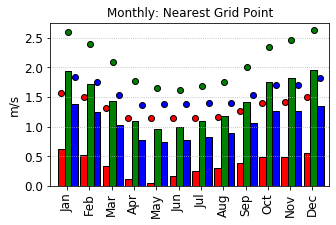

In [5]:
PlotMonthlyBarsDots(combo_error.rename(columns={'MERA wspd':'MERA','ERA-I wspd':'ERI','MERRA2 wspd':'MR2'}).groupby(combo_error.index.month).mean(),combo_error.rename(columns={'MERA wspd':'MERA','ERA-I wspd':'ERI','MERRA2 wspd':'MR2'}).groupby(combo_error.index.month).apply(rmse),'m/s',0,2.75,method=METHOD,fileNAME='monthly_'+METHOD)